In [1]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from PIL import Image
import clip
import numpy as np

# Load CSV file
csv_path = 'cat_dog1.csv'
df = pd.read_csv(csv_path)

# Assuming your CSV has 'image' and 'labels' columns
images = df['image'].values
labels = df['labels'].values

# Split the dataset
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

# Utilize the CLIP model to extract embeddings for each image in the dataset (both train and test dataset)
train_embeddings = []
test_embeddings = []

for image_path, label in zip(train_images, train_labels):
    # Load image using PIL and apply transformations
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    train_embeddings.append(embedding.cpu().numpy())

for image_path, label in zip(test_images, test_labels):
    # Load image using PIL and apply transformations
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    test_embeddings.append(embedding.cpu().numpy())

# Organize the extracted CLIP embeddings into a feature matrix
train_features = np.concatenate(train_embeddings)
test_features = np.concatenate(test_embeddings)

# Fisher Algorithm
lda = LinearDiscriminantAnalysis()
lda.fit(train_features, train_labels)


LinearDiscriminantAnalysis()

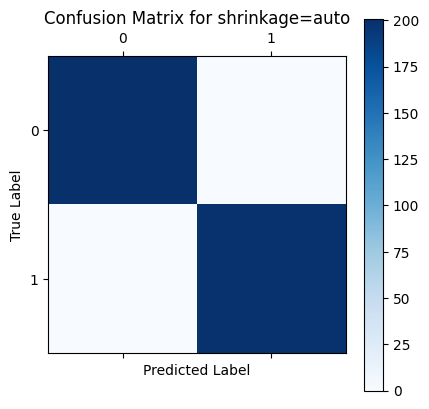

Confusion Matrix:
[[201   0]
 [  0 199]]

Metrics for shrinkage=auto:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


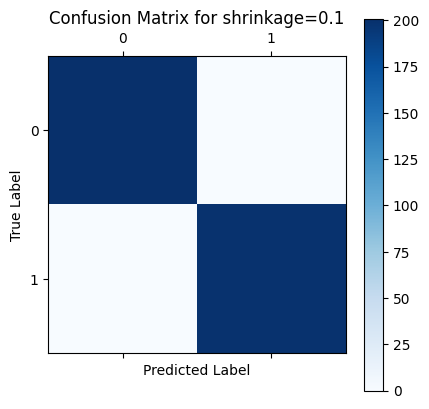

Confusion Matrix:
[[201   0]
 [  0 199]]

Metrics for shrinkage=0.1:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


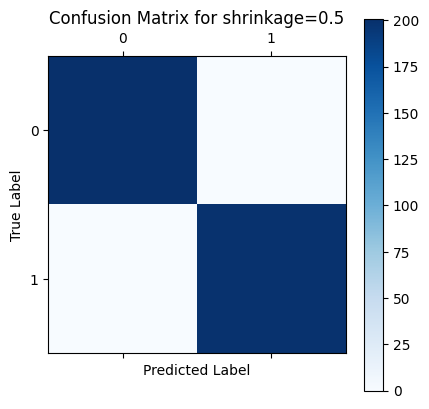

Confusion Matrix:
[[201   0]
 [  0 199]]

Metrics for shrinkage=0.5:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


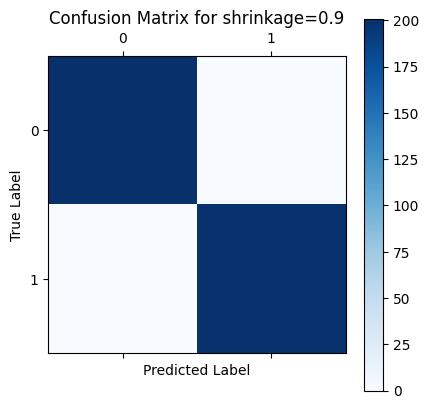

Confusion Matrix:
[[201   0]
 [  0 199]]

Metrics for shrinkage=0.9:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Best shrinkage value: auto with Accuracy: 1.0


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define the values for the parameter shrinkage
shrinkage_values = ['auto', 0.1, 0.5, 0.9]

# Initialize variables for tracking the best model
best_accuracy = 0.0
best_shrinkage = None

# ... (rest of your code)

for shrinkage in shrinkage_values:
    fisher_model = LinearDiscriminantAnalysis(solver='eigen', shrinkage=shrinkage)
    fisher_model.fit(train_features, train_labels)

    # Test the model using the testing dataset and visualize the classification results using a confusion matrix
    predictions = fisher_model.predict(test_features)
    confusion_mat = confusion_matrix(test_labels, predictions)

    # Visualize the confusion matrix
    plt.matshow(confusion_mat, cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for shrinkage={shrinkage}')
    plt.show()

    # Print the confusion matrix values
    print("Confusion Matrix:")
    print(confusion_mat)

    # Model Evaluation
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    recall = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)

    print(f"\nMetrics for shrinkage={shrinkage}:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # Check if the current model is the best based on accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_shrinkage = shrinkage

print(f"\nBest shrinkage value: {best_shrinkage} with Accuracy: {best_accuracy}")
